In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.manifold import TSNE  
from sklearn.cluster import AgglomerativeClustering, KMeans      
from scipy.cluster.hierarchy import dendrogram, linkage             
from sklearn.metrics import silhouette_score, davies_bouldin_score, plot_confusion_matrix       
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.cluster.hierarchy as shc
from gap_statistic import OptimalK
from kmeans_numpy import KMeans_numpy
%matplotlib inline
import warnings

# Clustering analysis using breast cancer data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. 

1) ID number

2) Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter): radius_mean, radius_se, radius_worst 

b) texture (standard deviation of gray-scale values): texture_mean, texture_se, texture_worst

c) perimeter: perimeter_mean, perimeter_se, perimeter_worst

d) area: area_mean, area_se, area_worst

e) smoothness (local variation in radius lengths): smoothness_mean, smoothness_se, smoothness_worst

f) compactness (perimeter^2 / area - 1.0): compactness_mean, compactness_se, compactness_worst

g) concavity (severity of concave portions of the contour): concavity_mean, concavity_se, concavity_worst

h) concave points (number of concave portions of the contour): concave points_mean, concave points_se, concave points_worst

i) symmetry: symmetry_mean, symmetry_se, symmetry_worst

j) fractal dimension ("coastline approximation" - 1): fractal_dimension_mean, fractal_dimension_se, fractal_dimension_worst

In [2]:
cancer = pd.read_csv('breast-cancer-data.csv')
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
cancer.drop(['Unnamed: 32', 'id'], axis = 1, inplace=True)

### Step 1. Data exploration

**The dataset consists of 569 data points, with 31 features each**

In [19]:
cancer.shape

(569, 31)

In [56]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [17]:
cancer.describe()  

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [4]:
# Check missing values
print(" \nCount total NaN at each column in a DataFrame : \n\n", cancer.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


**Of these 569 data points, 212 are labeled as malignant and 357 as benign**

Text(0.5, 1.0, 'Cancer diagnosis')

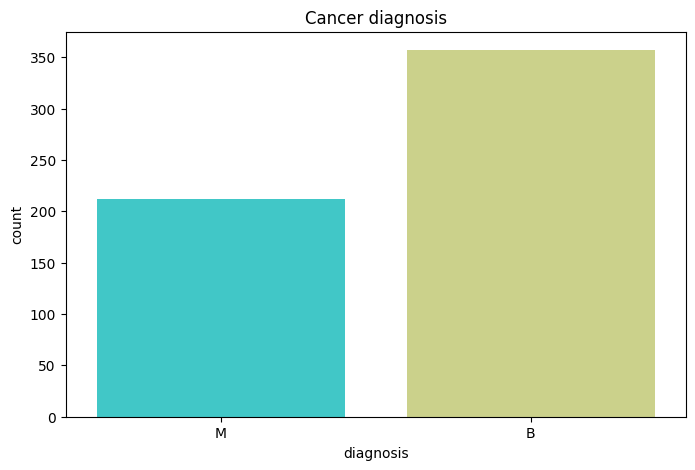

In [35]:
plt.figure(figsize=(8,5))
sns.countplot(x='diagnosis',data=cancer, palette='rainbow')
plt.title("Cancer diagnosis")

In [57]:
cancer['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [66]:
diagnosis=cancer.diagnosis
diagnosis.head()

0    M
1    M
2    M
3    M
4    M
Name: diagnosis, dtype: object

### Scatter plot after creating subsets by column names

In [6]:
ssets=[]
for start in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal_dimension']:
    subcol1=[col for col in cancer.columns if col.startswith(start+ '_')]+ ["diagnosis"]
    ssets.append(cancer[subcol1])
radius, texture, perimeter, area, smoothness, compactness, concavity, concave_points, symmetry, fractal_dimension=ssets
esets=[]
for end in ['mean', 'se', 'worst']:
    subcol2=[col for col in cancer.columns if col.endswith('_'+end)]+ ["diagnosis"]
    esets.append(cancer[subcol2])
mean, se, worst=esets

In [46]:
mean.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,M


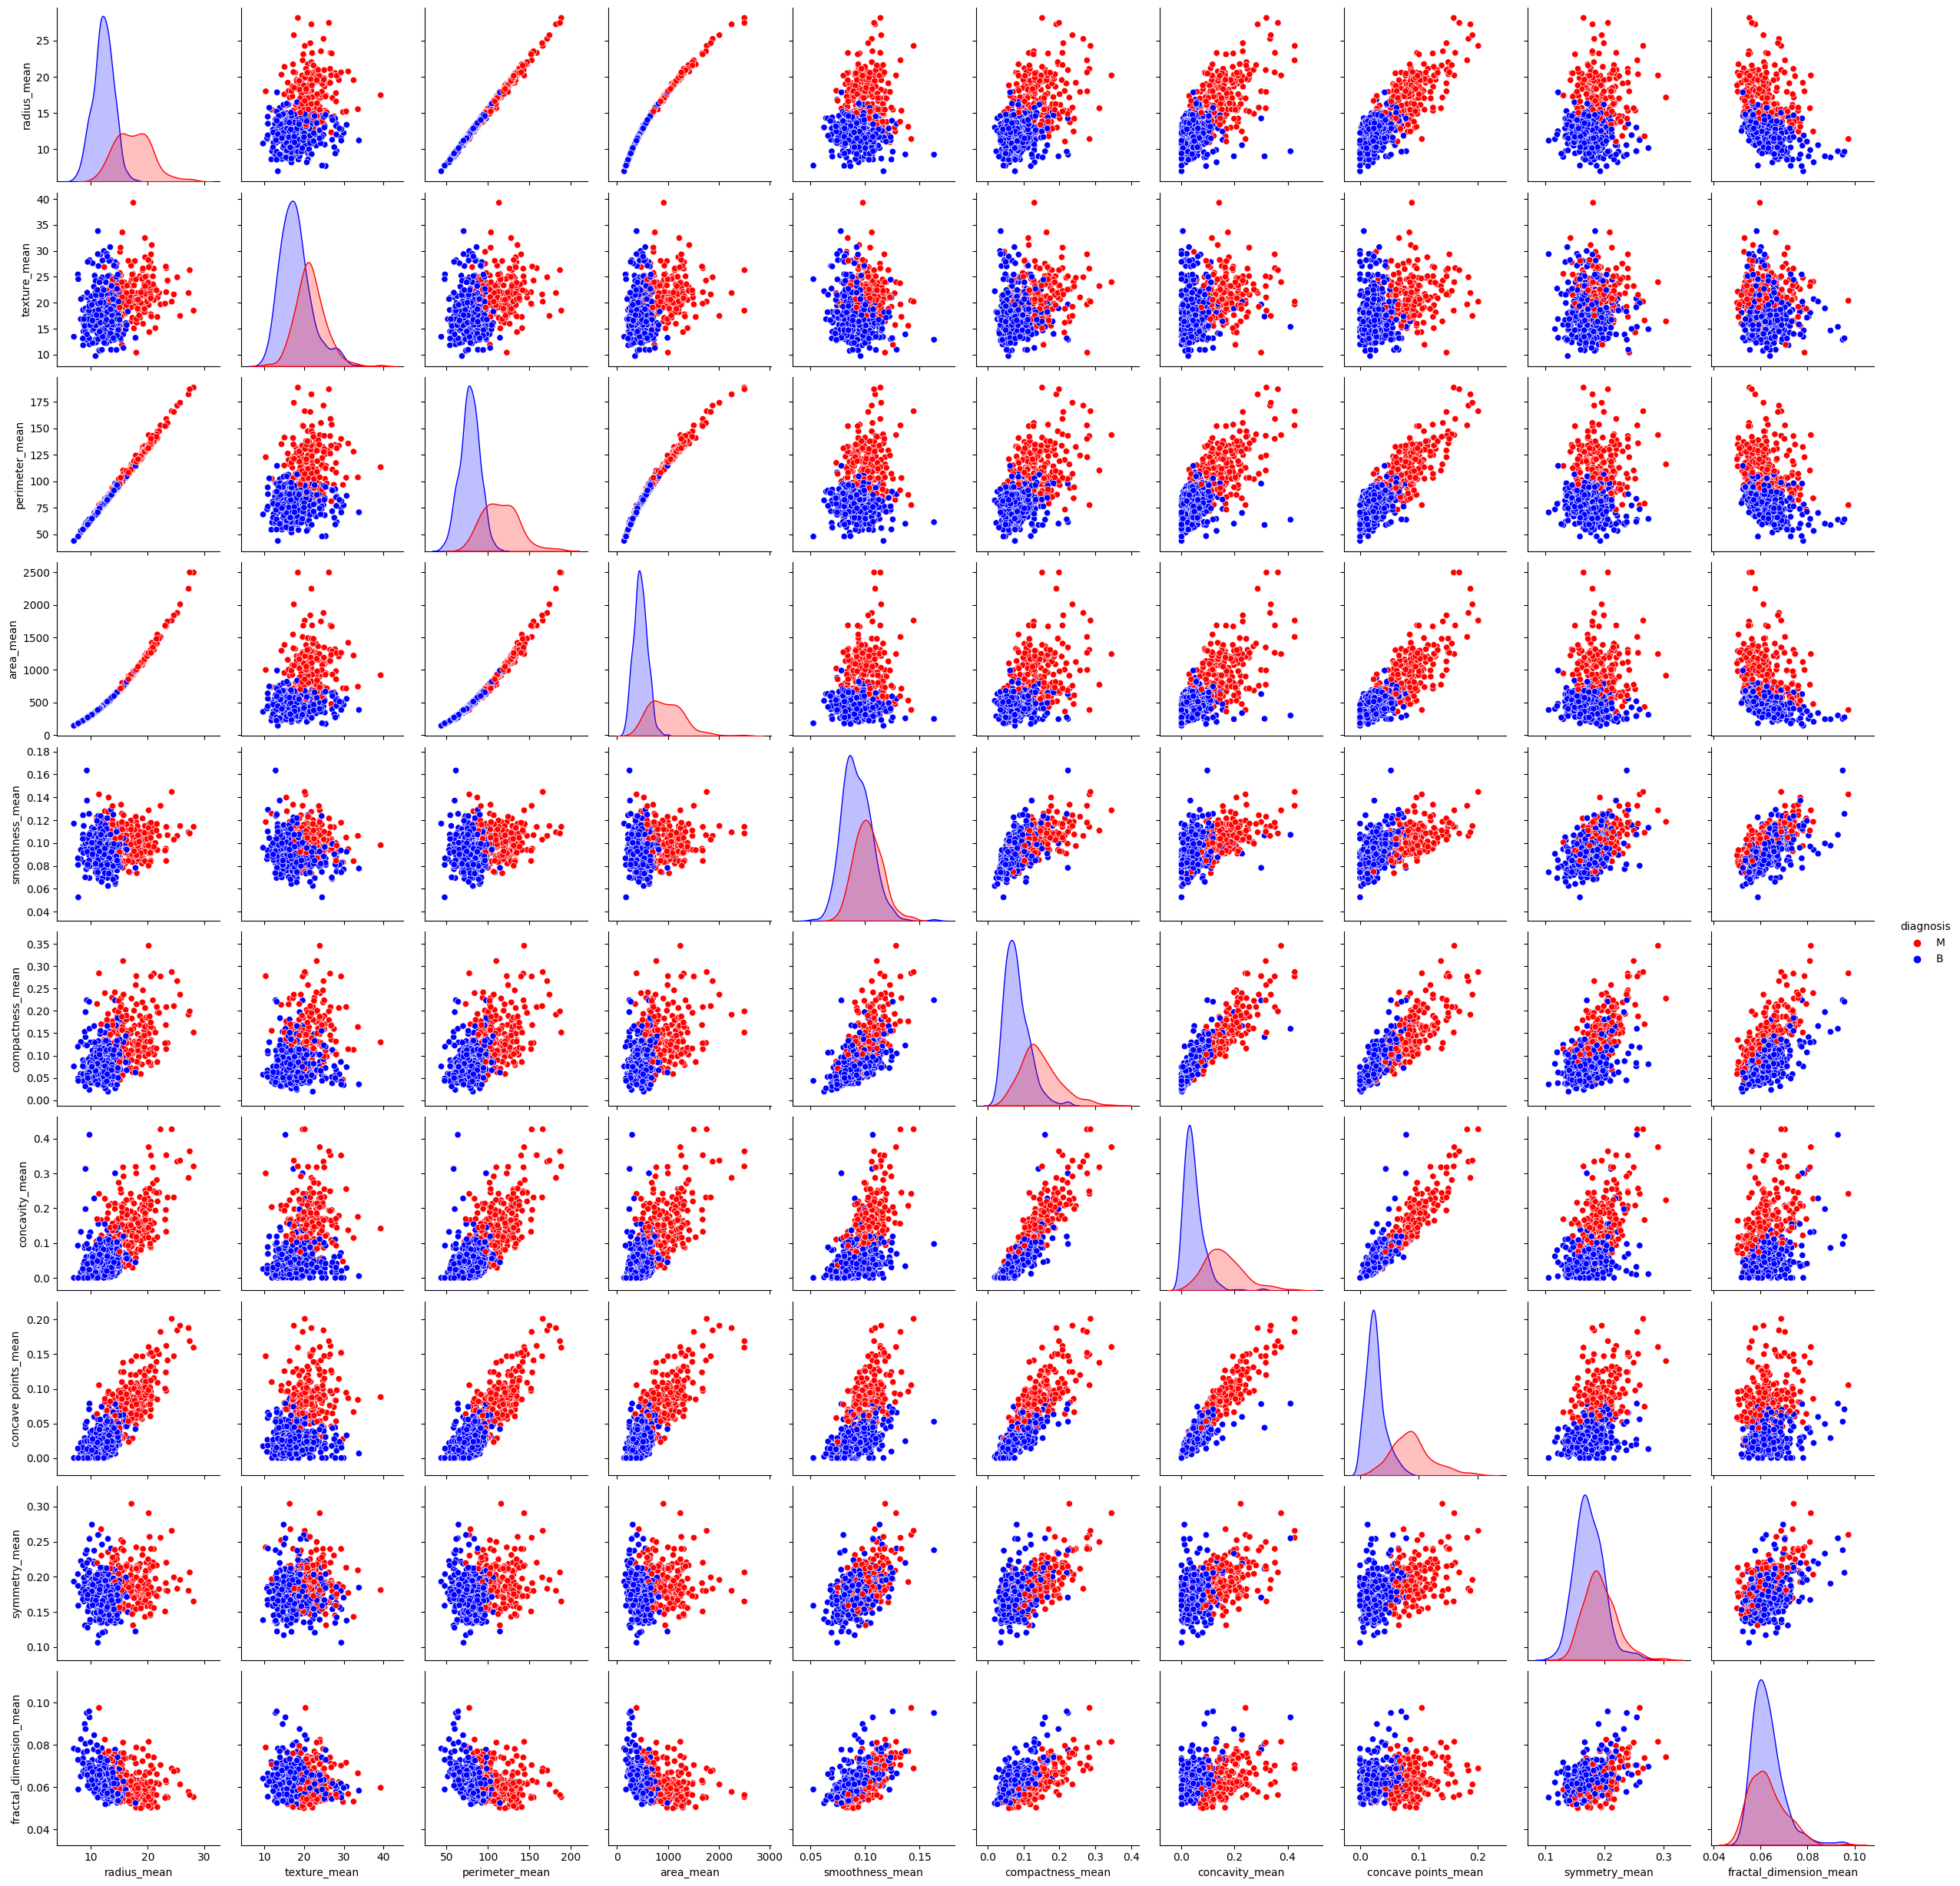

In [47]:
#scatter plot: same as Seaborn's PairGrid, but simple
sns.pairplot(mean, hue='diagnosis', palette=["red", "blue"])

### Rename Variables

- Convert diagnosis from character to numeric
- Sequentially renames all attribute columns (i.e., pixel data) as `P0`, `P2`, etc.
- Renames the diagnosis variable as `y`.

In [5]:
cancer['diagnosis'].replace({'B':0, 'M':1},inplace=True)
cancer['diagnosis'] = cancer['diagnosis'].astype('int64')

In [6]:
cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
cancer.columns = ["y"]+["P" + str(i) for i in range(0, len(cancer.columns) - 1)]

In [17]:
cancer.head()

,y,P0,P1,P2,P3,P4,P5,P6,P7,P8,...,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Standardize the data

In [7]:
cancer_st=cancer.copy(deep=True)
scaler = StandardScaler()
scaler.fit(cancer_st)
features = cancer_st.columns       
cancer_st[features] = scaler.transform(cancer_st[features])
cancer_st.head()

,y,P0,P1,P2,P3,P4,P5,P6,P7,P8,...,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29
0,1.297676,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.297676,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.297676,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,1.297676,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.297676,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


# Step 2. Dimensionality Reduction using PCA

### Determine no of components

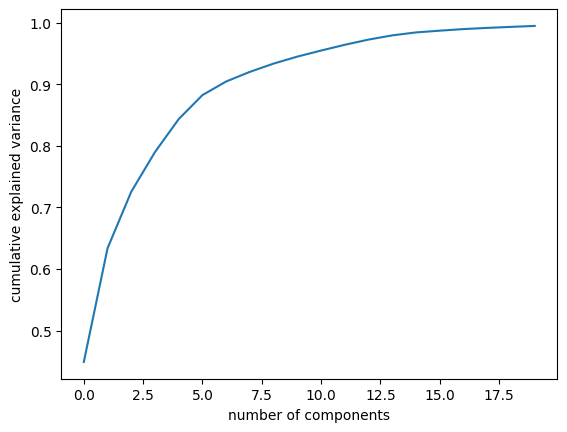

In [8]:
pca = PCA(n_components=20)
trn_tf = pca.fit_transform(cancer_st)
#Cumulative explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

**Interpretation**

10 componetns reach almost 99.9% of variances

In [9]:
pca = PCA(n_components=10)
trn_pca = pca.fit_transform(cancer_st)
trn_pca_data = pd.DataFrame(trn_pca)
trn_pca_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       569 non-null    float64
 1   1       569 non-null    float64
 2   2       569 non-null    float64
 3   3       569 non-null    float64
 4   4       569 non-null    float64
 5   5       569 non-null    float64
 6   6       569 non-null    float64
 7   7       569 non-null    float64
 8   8       569 non-null    float64
 9   9       569 non-null    float64
dtypes: float64(10)
memory usage: 44.6 KB


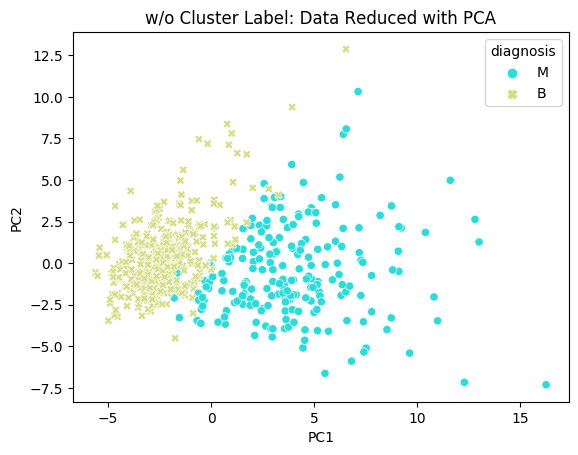

In [40]:
pc1_values = trn_pca[:,0]
pc2_values = trn_pca[:,1]
sns.scatterplot(x=pc1_values, y=pc2_values, style=diagnosis, hue=diagnosis, palette="rainbow")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('w/o Cluster Label: Data Reduced with PCA')
plt.show()

In [16]:
# Gets the average log likelihood score of training data (with two decimal places)
print("%.2f" % pca.score(cancer))

-103.08


# Step 3. Cluster analysis

## A. Determine the optimal no. of clusters

1. Gap Statistic
1. Elbow Method
1. Silhouette Coefficient
1. Calinski-Harabasz Index
1. Davies-Bouldin Index
1. Dendrogram
1. Bayesian information criterion (BIC)

## 1. Gap Statistic

In [44]:
optimalK = OptimalK(parallel_backend='rust')
optimalK

OptimalK(n_jobs=4, parallel_backend="rust")

In [45]:
n_clusters = optimalK(cancer_st, cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  13


In [46]:
optimalK.gap_df.head()

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,1.0,2.315699,279.505993,0.004327,70176.303216,81033.043593,0.001770,81126.102939
1,2.0,2.327181,861.876412,0.013252,70754.497573,81704.297296,0.008086,81642.990983
2,3.0,2.322584,225.732485,0.003489,70382.526567,81271.019977,0.010382,81152.870463
3,4.0,2.313598,89.431441,0.001396,69620.311548,80390.655444,-0.025881,80530.432928
4,5.0,2.342301,182.302090,0.002823,70522.960744,81433.082124,0.032557,81206.739428


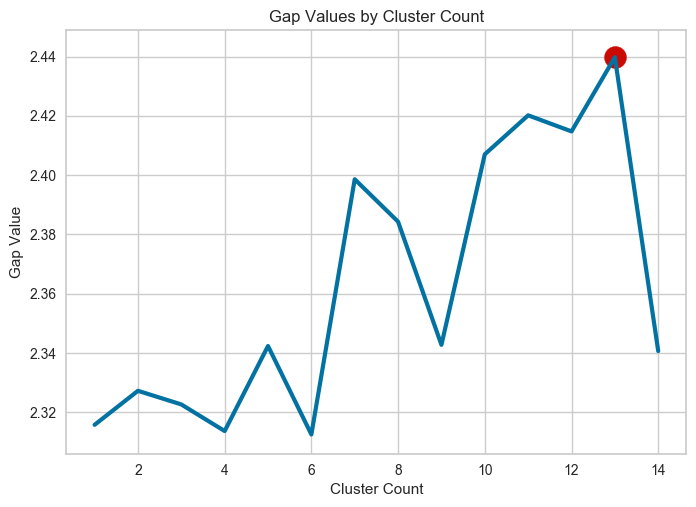

In [47]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

### 2. Elbow Method

In [41]:
from yellowbrick.cluster import KElbowVisualizer

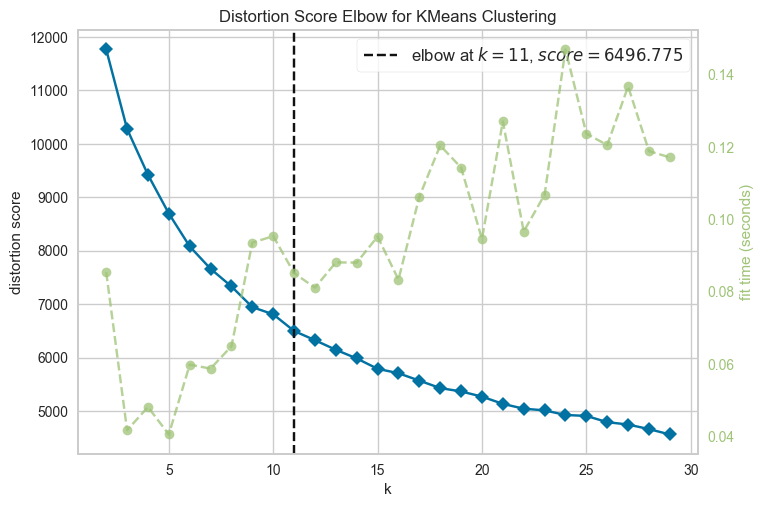

In [42]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(cancer_st)        # Fit data to visualizer
visualizer.show()                # Finalize and render figure

### 3. Silhouette Score

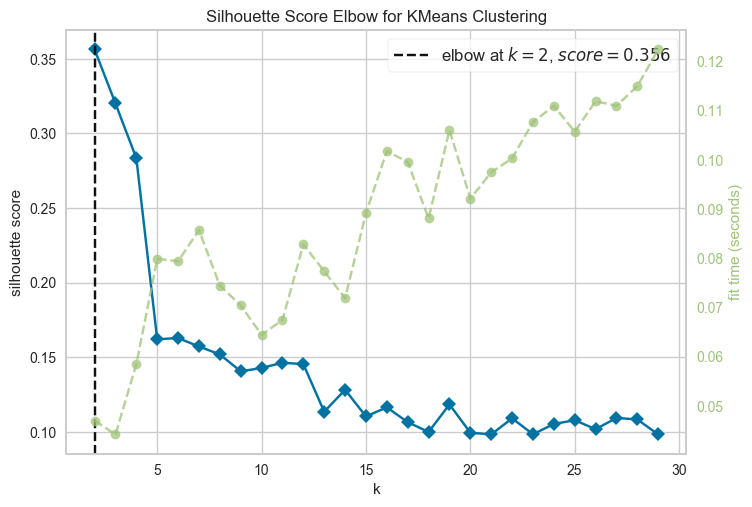

In [48]:
# model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(cancer_st)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### 4. Calinski Harabasz Score

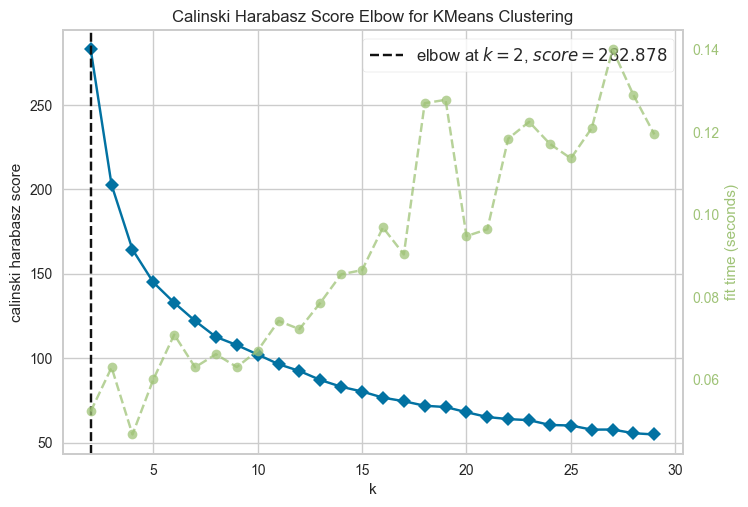

In [49]:
#model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(cancer_st)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### 5. Davies Bouldin score

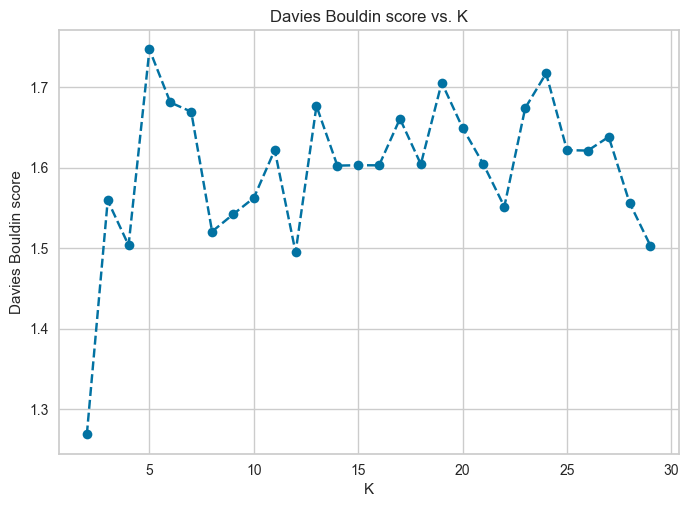

In [51]:
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit_predict(data)
    score = davies_bouldin_score(data, model)
    return score
scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_kmeans_score(cancer_st, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');

**Interpretation of Davies Bouldin score**

- the Davies Bouldin score is minimized with 2 clusters and can be considered as best for the k means algorithm

### 6. Dendogram

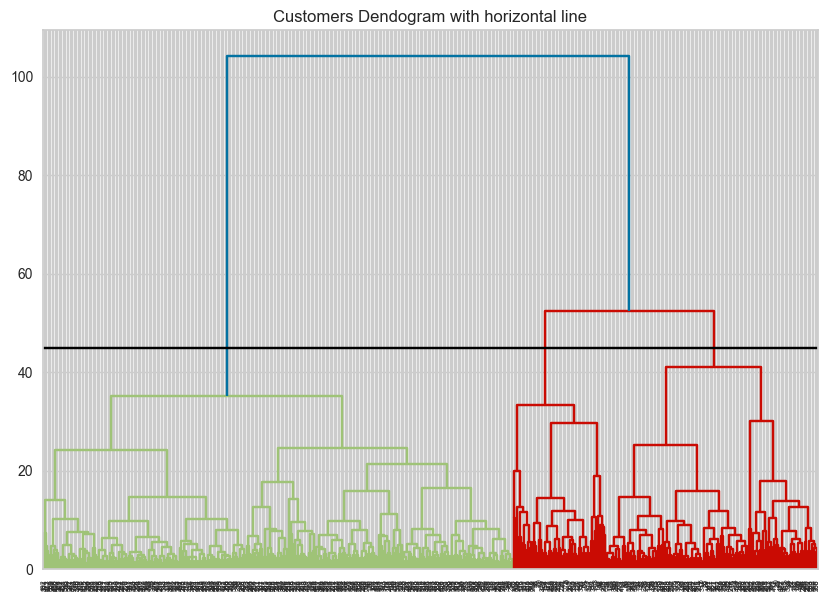

In [55]:
plt.figure(figsize=(10, 7))
plt.title("Customers Dendogram with horizontal line")
clusters = shc.linkage(cancer_st, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y =45, color = 'black', linestyle = '-')

**Interpretation of Dendogram**
- Dendogram with a horizontal line that passes through longest vertical lines (=longest distance)
- After locating the horizontal line, Count how many times our vertical lines were crossed by it. 
- Therefore, 3 seems a good indication of the number of clusters that have the most distance between them.

**Final evaluation**
1. Gap Statistic: k=13
1. Elbow Method: k=11
1. Silhouette Coefficient: k=2
1. Calinski-Harabasz Index: k=2
1. Davies-Bouldin Index: k=2
1. Dendrogram: k=3

**Therefore, I decide k=3**

## B. Cluster analysis

## 1. Agglomerative Hierarchical Clustering using PCA results

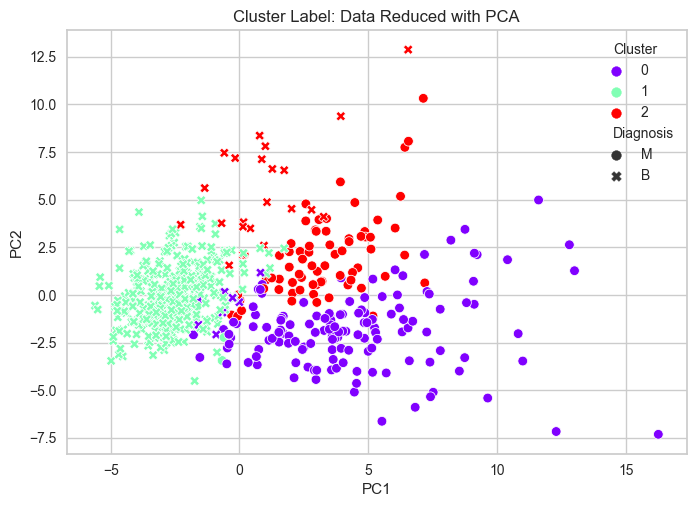

In [145]:
cluster_hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster_hc.fit(trn_pca)

cluster_hc_label= cluster_hc.labels_
trn_pca_data['Diagnosis'], trn_pca_data['Cluster_HA3']=[cancer.diagnosis, cluster_hc_label]
sns.scatterplot(data=trn_pca_data, x=pc1_values, y=pc2_values, style="Diagnosis", hue="Cluster", palette="rainbow")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cluster Label: Data Reduced with PCA')
plt.show()

**INTERPRETATION**
- M is divided into 2 clusters (0, 2)
- Benign is divied into 2 clusteres (cluster 1 & 2)
- Cluster 2 has mixed B & M

In [143]:
cluster_hc.get_params()

{'affinity': 'euclidean',
 'compute_distances': False,
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'ward',
 'memory': None,
 'n_clusters': 3}

In [150]:
cluster_hc2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster_hc2.fit(trn_pca)
cluster_hc_label2= cluster_hc2.labels_
trn_pca_data['Cluster_HA2']=cluster_hc_label2
sns.scatterplot(data=trn_pca_data, x=pc1_values, y=pc2_values, style="Diagnosis", hue="Cluster_HA2", palette="rainbow")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Hierarchical Cluster Label: Data Reduced with PCA')
plt.show()

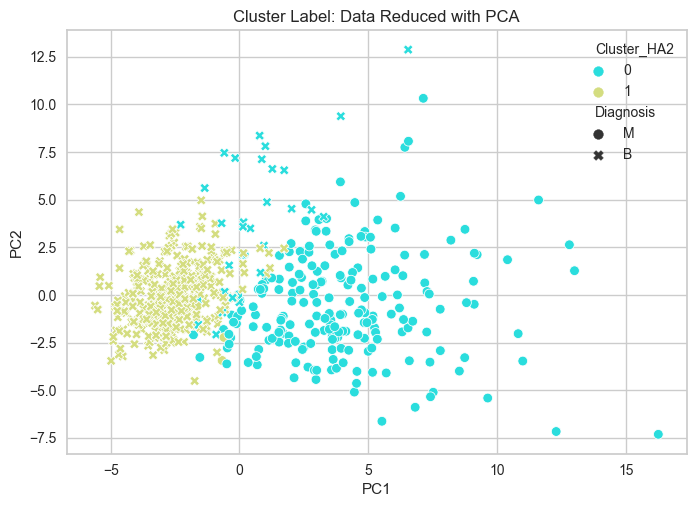

### Follow-up analysis after building the clusters

In [155]:
cluster_hc2.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [159]:
cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,d_mal,Cluster_HA3,Cluster_HA2
0,M,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,0.24,...,2019.00,0.16,0.67,0.71,0.27,0.46,0.12,1,0,0
1,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,...,1956.00,0.12,0.19,0.24,0.19,0.28,0.09,1,0,0
2,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,...,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,1,0,0
3,M,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,0.26,...,567.70,0.21,0.87,0.69,0.26,0.66,0.17,1,2,0
4,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,...,1575.00,0.14,0.20,0.40,0.16,0.24,0.08,1,0,0


In [158]:
# Append cluster cloumn to the orginal data
cancer['Cluster_HA3'] = cluster_hc.labels_.tolist()
cancer['Cluster_HA2'] = cluster_hc2.labels_.tolist()

In [106]:
cancer = pd.concat([cancer, pd.get_dummies(cancer['diagnosis'])], axis=1)
cancer.drop('B', axis=1, inplace=True)
cancer.rename(columns={'M': 'd_mal'}, inplace=True)
pd.crosstab(index=cancer['diagnosis'], columns=cancer['d_mal'], normalize=True, margins=True, margins_name="Total")

In [115]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cancer.groupby('Cluster_HA3').agg({'d_mal': ["count", "mean"],'perimeter_mean':"mean", 'concave points_mean': "mean", 'area_se': "mean", 'radius_worst': "mean", 'perimeter_worst': "mean", 'area_worst': "mean", 'concave points_worst': "mean"})

d_mal      perimeter_mean concave points_mean area_se radius_worst  \
           count mean           mean                mean    mean         mean   
Cluster_ha                                                                      
0            147 0.94         123.25                0.09   87.02        22.61   
1            330 0.01          78.20                0.02   21.23        13.42   
2             92 0.76          91.36                0.07   34.29        16.35   

           perimeter_worst area_worst concave points_worst  
                      mean       mean                 mean  
Cluster_ha                                                  
0                   150.88    1616.26                 0.18  
1                    87.07     562.03                 0.07  
2                   110.00     847.75                 0.17

In [160]:
cancer.groupby('Cluster_HA2').agg({'d_mal': ["count", "mean"],'perimeter_mean':"mean", 'concave points_mean': "mean", 'area_se': "mean", 'radius_worst': "mean", 'perimeter_worst': "mean", 'area_worst': "mean", 'concave points_worst': "mean"})

d_mal      perimeter_mean concave points_mean area_se  \
            count mean           mean                mean    mean   
Cluster_HA2                                                         
0             239 0.87         110.98                0.08   66.72   
1             330 0.01          78.20                0.02   21.23   

            radius_worst perimeter_worst area_worst concave points_worst  
                    mean            mean       mean                 mean  
Cluster_HA2                                                               
0                  20.20          135.14    1320.43                 0.18  
1                  13.42           87.07     562.03                 0.07

## 2. K-Means

### No of Clusters=3

In [164]:
# Sets up the kMeans object
km3 = KMeans(n_clusters=3, random_state=1, init='k-means++', n_init=10)

# Fits the model to the data
trn_km3=km3.fit(cancer_st)

# Displays the parameters of the fitted model
km3.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 3,
 'n_init': 10,
 'random_state': 1,
 'tol': 0.0001,
 'verbose': 0}

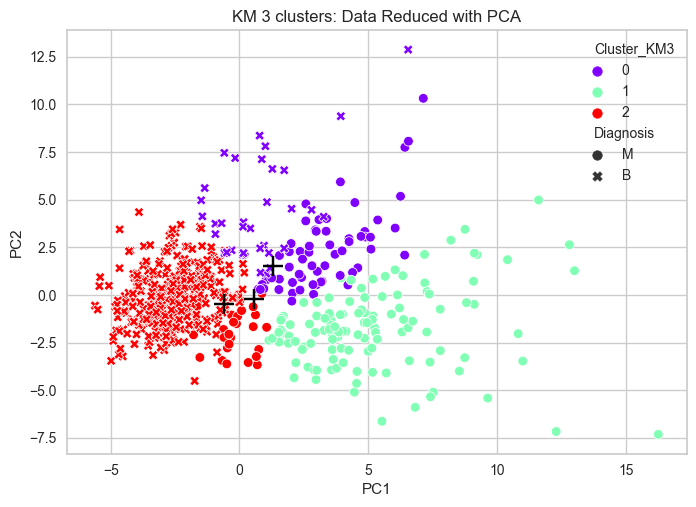

In [167]:
cluster_km_label3 = km3.labels_
trn_pca_data['Cluster_KM3']=cluster_km_label3
# Creates a scatter plot
sns.scatterplot(data=trn_pca_data, x=pc1_values, y=pc2_values, style="Diagnosis", hue="Cluster_KM3", palette="rainbow")

# Adds cluster centers to the same plot
plt.scatter(
    km3.cluster_centers_[:, 0],
    km3.cluster_centers_[:, 1],
    marker='+',
    s=200,
    c='black')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KM_3 clusters: Data Reduced with PCA')
plt.show()

### No of Clusters=2

In [161]:
# Sets up the kMeans object
km2 = KMeans(n_clusters=2, random_state=1, init='k-means++', n_init=10)

# Fits the model to the data
trn_km2=km2.fit(cancer_st)

# Displays the parameters of the fitted model
km2.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 10,
 'random_state': 1,
 'tol': 0.0001,
 'verbose': 0}

In [129]:
cancer_st.shape

(569, 31)

In [162]:
#Since fit data (cancer_st) have 31 columns, trn_km.cluster_centers_ has 31 columns
trn_km2.cluster_centers_

array([[-0.59240129, -0.49650853, -0.24839186, -0.51093484, -0.49015195,
        -0.27924496, -0.48344912, -0.55348434, -0.57431271, -0.28684152,
        -0.08713807, -0.4253892 , -0.01706176, -0.42199483, -0.40420997,
         0.00338837, -0.31173203, -0.29441088, -0.36091121, -0.06696603,
        -0.177062  , -0.52996945, -0.26460479, -0.53962875, -0.510571  ,
        -0.2930803 , -0.4531358 , -0.5042453 , -0.56529846, -0.30329136,
        -0.28326714],
       [ 1.21983706,  1.02238046,  0.51147356,  1.05208625,  1.00929138,
         0.57500441,  0.99548932,  1.13970162,  1.18259014,  0.59064678,
         0.17942948,  0.87593582,  0.03513255,  0.86894635,  0.83232483,
        -0.00697712,  0.64189983,  0.60623316,  0.74316664,  0.13789242,
         0.36459541,  1.09128117,  0.54485824,  1.11117102,  1.05133707,
         0.60349331,  0.93306996,  1.03831156,  1.16402855,  0.62451931,
         0.58328663]])

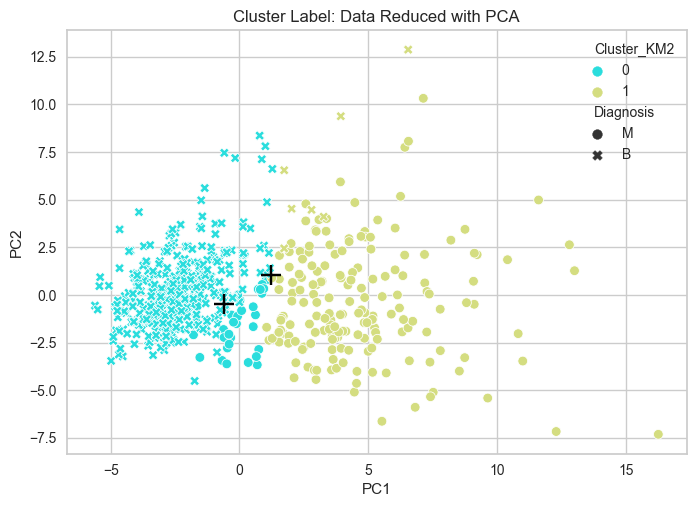

In [163]:
cluster_km_label2 = km2.labels_
trn_pca_data['Cluster_KM2']=cluster_km_label2
# Creates a scatter plot
sns.scatterplot(data=trn_pca_data, x=pc1_values, y=pc2_values, style="Diagnosis", hue="Cluster_KM2", palette="rainbow")

# Adds cluster centers to the same plot
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    marker='+',
    s=200,
    c='black')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KM_2 clusters: Data Reduced with PCA')
plt.show()

## Inspecting analysis of K-Means cluster

Source: https://github.com/lucko515/clustering-pytho

In [170]:
inspect_km2 = KMeans_numpy(n_clusters=2, tolerance=0.00001)

In [187]:
cancer2=cancer.copy(deep=True)
cancer2.drop(['diagnosis', 'Cluster_HA3', 'Cluster_HA2'], axis=1, inplace=True)

In [188]:
cancer2.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,d_mal
0,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,0.24,0.08,...,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12,1
1,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,...,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09,1
2,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,...,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,1
3,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,0.26,0.10,...,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17,1
4,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,...,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08,1


In [189]:
features = cancer2.values

In [174]:
print(features)

[['M' 17.99 10.38 ... 1 0 0]
 ['M' 20.57 17.77 ... 1 0 0]
 ['M' 19.69 21.25 ... 1 0 0]
 ...
 ['M' 16.6 28.08 ... 1 0 0]
 ['M' 20.6 29.33 ... 1 0 0]
 ['B' 7.76 24.54 ... 0 1 1]]


In [190]:
clust_km2, clust_data_km2 = inspect_km2.fit(features)

In [191]:
km2_cluster_one = pd.DataFrame(clust_data_km2[0], columns=cancer2.columns)
km2_cluster_two = pd.DataFrame(clust_data_km2[1], columns=cancer2.columns)

In [193]:
print("Shape of All :", cancer2.shape)
print("Shape of Cluster 1 of 2:", km2_cluster_one.shape)
print("Shape of Cluster 2 of 2:", km2_cluster_two.shape)

Shape of All : (569, 31)
Shape of Cluster 1 of 2: (438, 31)
Shape of Cluster 2 of 2: (131, 31)


In [194]:
inspect_km3 = KMeans_numpy(n_clusters=3, tolerance=0.00001)

In [197]:
clust_km3, clust_data_km3 = inspect_km3.fit(features)

In [198]:
km3_cluster_one = pd.DataFrame(clust_data_km3[0], columns=cancer2.columns)
km3_cluster_two = pd.DataFrame(clust_data_km3[1], columns=cancer2.columns)
km3_cluster_three = pd.DataFrame(clust_data_km3[2], columns=cancer2.columns)

In [199]:
print("Shape of All :", cancer2.shape)
print("Shape of Cluster 1 of 3:", km3_cluster_one.shape)
print("Shape of Cluster 2 of 3:", km3_cluster_two.shape)
print("Shape of Cluster 3 of 3:", km3_cluster_three.shape)

Shape of All : (569, 31)
Shape of Cluster 1 of 3: (339, 31)
Shape of Cluster 2 of 3: (146, 31)
Shape of Cluster 3 of 3: (84, 31)


In [200]:
km3_cluster_one.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,d_mal
0,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,0.26,0.10,...,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17,1.00
1,12.45,15.70,82.57,477.10,0.13,0.17,0.16,0.08,0.21,0.08,...,23.75,103.40,741.60,0.18,0.52,0.54,0.17,0.40,0.12,1.00
2,13.00,21.82,87.50,519.80,0.13,0.19,0.19,0.09,0.23,0.07,...,30.73,106.20,739.30,0.17,0.54,0.54,0.21,0.44,0.11,1.00
3,12.46,24.04,83.97,475.90,0.12,0.24,0.23,0.09,0.20,0.08,...,40.68,97.65,711.40,0.19,1.06,1.10,0.22,0.44,0.21,1.00
4,13.73,22.61,93.60,578.30,0.11,0.23,0.21,0.08,0.21,0.08,...,32.01,108.80,697.70,0.17,0.77,0.69,0.22,0.36,0.14,1.00


### 3 clusters: First cluster analysis

In [220]:
benign = km3_cluster_one.loc[(km3_cluster_one['d_mal'] == 0.0)]
print("First cluster: Out of 339 patients, {} benign and rest malignant.".format(benign.shape[0]))

First cluster: Out of 339 patients, 316 benign and rest malignant.


In [215]:
benign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 5 to 338
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              316 non-null    float64
 1   texture_mean             316 non-null    float64
 2   perimeter_mean           316 non-null    float64
 3   area_mean                316 non-null    float64
 4   smoothness_mean          316 non-null    float64
 5   compactness_mean         316 non-null    float64
 6   concavity_mean           316 non-null    float64
 7   concave points_mean      316 non-null    float64
 8   symmetry_mean            316 non-null    float64
 9   fractal_dimension_mean   316 non-null    float64
 10  radius_se                316 non-null    float64
 11  texture_se               316 non-null    float64
 12  perimeter_se             316 non-null    float64
 13  area_se                  316 non-null    float64
 14  smoothness_se            3

In [218]:
small_concave_worst = benign.loc[(benign['concave points_worst'] <0.07)]
big_concave_worst = benign.loc[(benign['concave points_worst'] >= 0.07)]
print("First cluster: {} of 316 patients with benign have concave points worst, smaller than median, {} bigger than median.".format(small_concave_worst.shape[0], big_concave_worst.shape[0]))

First cluster: 163 of 316 patients with benign have concave points worst, smaller than median, 153 bigger than median.


### 3 clusters: Second cluster analysis

In [223]:
malig2 = km3_cluster_two.loc[(km3_cluster_two['d_mal'] == 1.0)]
print("Second cluster: Out of 146 patients, {} malignant and rest benign.".format(malig2.shape[0]))

Second cluster: Out of 146 patients, 105 malignant and rest benign.


In [229]:
malig2['radius_worst'].mean()

19.02704761904762

In [225]:
small_concave_worst = malig2.loc[(malig2['concave points_worst'] <0.17)]
big_concave_worst = malig2.loc[(malig2['concave points_worst'] >= 0.17)]
print("Second cluster: {} of 146 patients with malignant cancer have concave points worst, smaller than median, {} bigger than median.".format(small_concave_worst.shape[0], big_concave_worst.shape[0]))

Second cluster: 54 of 146 patients with malignant cancer have concave points worst, smaller than median, 51 bigger than median.


In [232]:
small_radius_worst = big_concave_worst.loc[(big_concave_worst['radius_worst'] <19.02)]
big_radius_worst = big_concave_worst.loc[(big_concave_worst['radius_worst'] >= 19.02)]
print("Second cluster: {} of 51 patients with malignant cancer with big concave points worst has small raius worst, {} bigger than median.".format(small_radius_worst.shape[0], big_radius_worst.shape[0]))

Second cluster: 24 of 51 patients with malignant cancer with big concave points worst has small raius worst, 27 bigger than median.


In [234]:
#list partients with malignant breast cancer whose concave points worst and radius are bigger than mean
big_radius_worst

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,d_mal
2,15.78,17.89,103.60,781.00,0.10,0.13,0.10,0.07,0.18,0.06,...,27.28,136.50,1299.00,0.14,0.56,0.40,0.18,0.38,0.10,1.00
3,19.17,24.80,132.40,1123.00,0.10,0.25,0.21,0.11,0.24,0.08,...,29.94,151.70,1332.00,0.10,0.39,0.36,0.18,0.32,0.10,1.00
7,16.13,20.68,108.10,798.80,0.12,0.20,0.17,0.10,0.22,0.07,...,31.48,136.80,1315.00,0.18,0.42,0.48,0.21,0.37,0.11,1.00
9,17.14,16.40,116.00,912.70,0.12,0.23,0.22,0.14,0.30,0.07,...,21.40,152.40,1461.00,0.15,0.39,0.39,0.26,0.41,0.11,1.00
12,15.30,25.27,102.40,732.40,0.11,0.17,0.17,0.09,0.19,0.07,...,36.71,149.30,1269.00,0.16,0.61,0.63,0.20,0.40,0.10,1.00
14,17.02,23.98,112.80,899.30,0.12,0.15,0.24,0.12,0.22,0.06,...,32.09,136.10,1344.00,0.16,0.36,0.56,0.18,0.35,0.08,1.00
15,16.13,17.88,107.00,807.20,0.10,0.16,0.14,0.08,0.20,0.07,...,27.26,132.70,1261.00,0.14,0.58,0.53,0.19,0.43,0.12,1.00
16,16.74,21.59,110.10,869.50,0.10,0.13,0.13,0.06,0.19,0.06,...,29.02,133.50,1229.00,0.16,0.38,0.54,0.18,0.49,0.09,1.00
27,19.10,26.29,129.10,1132.00,0.12,0.18,0.19,0.15,0.16,0.07,...,32.72,141.30,1298.00,0.14,0.28,0.24,0.18,0.23,0.09,1.00
37,15.78,22.91,105.70,782.60,0.12,0.18,0.21,0.09,0.21,0.07,...,30.50,130.30,1272.00,0.19,0.49,0.74,0.20,0.33,0.13,1.00
